# 🚧 TorchBrain Notebook v20240808 🚧

### This notebook is currently in beta. Please be aware of the following:

### Info
- demonstration of burst suppression (tauC set to 0.1)

### Known Bugs
- ❗ use_small_eigs is broken.

### To-Do List
- [ ] fix use_small_eigs
- [ ] try batch on GPU


In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle as pkl
import seaborn as sns
import torch
import torch.nn as nn

from scipy import signal
from torchdiffeq import odeint_adjoint as odeint
# from torchdiffeq import odeint

from tqdm.notebook import tqdm

plt.rcParams["figure.dpi"] = 300

In [2]:
def reorder_neonatal_connectome(Connectome, Distance_matrix, save=False, cortexstart=0):
    permutation = np.concatenate(
        [np.arange(cortexstart, 72), np.arange(78,90), np.arange(72, 78)]
    )
    Connectome = Connectome[permutation,][:, permutation]
    Distance_matrix = Distance_matrix[permutation,][:, permutation]
    return Connectome, Distance_matrix, permutation

def is_hermitian(matrix):
    # conjugate transpose of the last two dimensions (for linalg.eigh)
    conj_transpose = matrix.transpose(-2, -1).conj()
    return torch.equal(matrix, conj_transpose)

# SGM_ODE

#### Goodwin oscillator system equations (2 var)
A given gene is transcribed into mRNA (X) which is then translated into protein (Y). 
Y acts as a repressor: it inhibits mRNA synthesis (X)
dX_dt = self.alpha1 * (self.K / (self.K + Y)) - self.delta1
dY_dt = self.alpha2 * X - self.delta2


Δ = p/μ\
p = f(Δ, α)\
α_t+1 = α_t * Δ

α_0 = 1\
Δ_0 = 2

Δ is adaptation\
α is coupling constant\
μ is a constant = population average of p\
f is function that determines total power of power spectral density based on α.

In [3]:
class F(nn.Module):
    def __init__(self,
                params: torch.Tensor):
        super().__init__()
        # Define constants and tensors that do not change between calls
        self.params = params

        self.tauC = 0.1
        self.a = 0.5
        self.zero_thr = 0.05
        self.freqs = torch.tensor(np.arange(1,51), dtype=torch.float32)
        # self.freqs = self.freqs.requires_grad_(True)
        num_param_sets = params.shape[0]

        if 0:
            D = torch.rand((self.nroi, self.nroi), dtype=torch.float32)
            self.D = torch.tril(D) + torch.tril(D, -1).T        
            C = torch.rand((self.nroi, self.nroi), dtype=torch.float32)
            self.C = torch.tril(C) + torch.tril(C, -1).T
        else:
            neo_dir = "/Users/dbernardo/Documents/pyres/sgm_sbi/spectrome/spectrome/data/neonate/"
            C = np.genfromtxt(os.path.join(neo_dir, "neonate_weighted_fibercount_N10.csv"), delimiter=",", skip_header=1)
            D = np.genfromtxt(os.path.join(neo_dir, "neonate_fiberlength.csv"), delimiter=",", skip_header=0)
            C, D, perm_ = reorder_neonatal_connectome(C, D)
            self.C = torch.tensor(C)
            self.D = torch.tensor(D)

        self.nroi = C.shape[-1]
        self.K = self.nroi
        
        rowdegree, coldegree = torch.sum(self.C, dim=1), torch.sum(self.C, dim=0)
        combined_degree = rowdegree + coldegree
        threshold = 0.2 * torch.mean(combined_degree)
        qind = combined_degree < threshold
        rowdegree[qind], coldegree[qind] = float('inf'), float('inf')
        rowdegree = rowdegree.unsqueeze(1).T
        
        self.L1 = torch.eye(self.nroi)
        self.L2 = 1 / (torch.sqrt(rowdegree * coldegree) + torch.finfo(torch.float32).eps)

    def f(self, alphas, giis):
        tau_es, tau_is, alphas_, speeds, geis, giis_ = torch.unbind(self.params, dim=1)

        # Calculate w for all frequencies 
        w_expanded = 2 * np.pi * self.freqs  # Shape (50,)
        
        # Calculate Tau for all speeds
        Tau = 0.001 * self.D[None, :, :] / speeds[:, None, None]  
        
        # Broadcasting w_expanded to match Tau's last dimension
        w_broadcasted = w_expanded[None, None, None, :]        
        r = Tau[..., None] * w_broadcasted  
        C_broadcasted = self.C[None, :, :, None]          
        Cc_arr = C_broadcasted * torch.exp(-1j * r)  
        Cc_arr = Cc_arr.permute(0, 3, 1, 2)
        
        # Calculate L using the already vectorized Cc_arr and other variables
        L = self.L1[None, None, :, :] - alphas[:, None, None, None] * (self.L2[None, None, :, None] * Cc_arr)
        
        # Eigen decomposition
        if 1:
            d, v = torch.linalg.eigh(L)
        else:
            # for differentiable
            d, v = torch.linalg.eigh(L.real)
        
        # Vectorized approach to sort and select eigenvalues and eigenvectors
        eig_ind = torch.argsort(torch.abs(d), dim=-1)  # Sorting along the last dimension
        eig_val = torch.gather(d, -1, eig_ind)  # Re-indexing eigenvalues with same sorted index        
        eig_vec = torch.gather(v, -2, eig_ind.unsqueeze(-1).expand(-1, -1, -1, self.K, self.K))

        # Transpose eigenvalues and select the first K eigenvectors across all sets
        eigenvalues = eig_val.permute(0, 1, 3, 2)
        eigenvalues = eigenvalues.squeeze(0)  
        eigenvectors = eig_vec[..., :self.K]  # Selecting the first K eigenvectors across all sets
        
        # Broadcast params
        alpha_broadcasted = alphas[:, None, None]
        gei_broadcasted = geis[:, None, None]
        giis_broadcasted = giis[:, None, None]  
        tau_es_broadcasted = tau_es[:, None, None] 
        tau_is_broadcasted = tau_is[:, None, None] 
        
        # Calculate cortical model
        Fe = torch.div(1 / tau_es_broadcasted ** 2, (1j * w_expanded[None, None, None, :] + 1 / tau_es_broadcasted) ** 2)
        Fi = torch.div(giis_broadcasted / tau_is_broadcasted ** 2, (1j * w_expanded[None, None, None, :] + 1 / tau_is_broadcasted) ** 2)  
        Hed = alpha_broadcasted / tau_es_broadcasted / (1j * w_expanded[None, None, None, :] + alpha_broadcasted / tau_es_broadcasted * Fe)
        Hid = alpha_broadcasted / tau_is_broadcasted / (1j * w_expanded[None, None, None, :] + alpha_broadcasted / tau_is_broadcasted * Fi)
        Heid = gei_broadcasted * Fe * Fi / (1 + gei_broadcasted * Fe * Fi)
        Htotal = self.a * Hed + (1 - self.a) / 2 * Hid + (1 - self.a) / 2 * Heid
        Htotal = Htotal.squeeze(0).squeeze(1)

        # Broadcast Fe across eigenvalues
        Fe_eigenvalues = Fe * eigenvalues  
        
        # Combine alpha, Fe, and eigenvalues 
        alpha_tauC = (alpha_broadcasted / self.tauC)  
        complex_term = 1j * w_broadcasted + alpha_tauC * Fe_eigenvalues 
        q1 = (1 / alpha_broadcasted) * self.tauC * complex_term  
        q1_rh = torch.max(torch.abs(q1), dim=2, keepdim=True)[0]
        qthr = self.zero_thr * q1_rh
        magq1 = torch.maximum(torch.abs(q1), qthr)
        angq1 = torch.angle(q1)
        q1_updated = magq1 * torch.exp(1j * angq1)

        Htotal = Htotal[:, None, :]  
        
        frequency_response = Htotal / q1_updated  
        frequency_response = frequency_response.permute(0, 1, 3, 2)
        product = frequency_response[:, :, :, np.newaxis, :] * eigenvectors
        
        model_out = torch.sum(product[:, :, :, :, 1:], dim=-1)  
        model_out = model_out.squeeze(0)
        model_out = model_out.permute(0, 2, 1)
        
        return model_out

    def calc_slope(self, X, Y):
        X = (X - X.mean()) / X.std()
        Y_repeated = Y.repeat(X.size(0), 1)
        psd_stat = ((X * Y_repeated).mean(dim=1) - X.mean(dim=1) * Y.mean(dim=0)) / ((X**2).mean(dim=1) - (X.mean(dim=1))**2)
        return psd_stat
        
    def forward(self, 
                t: float, # time index
                state: torch.TensorType, # state of the system first dimension is the batch size
                ) -> torch.Tensor:

        alphas = state[..., 0] # first dimension is the batch size
        # alphas = alphas.requires_grad_(True)
        epsilon = state[..., 1]
        # p = p.requires_grad_(True)
        giis = state[..., 2]
        epsilon2 = state[..., 3]

        model_out = self.f(alphas, giis)
        model_out = torch.abs(model_out)
        model_out = torch.square(torch.mean(model_out, dim=1))

        # Base feedback on total power
        if 1:
            psd_stat = torch.trapezoid(model_out, self.freqs)
        else:
            psd_stat = self.calc_slope(model_out, self.freqs) 
        
        # Parameters for the Goodwin oscillator model
        alpha1, alpha2, alpha3 = .5, 5, 8
        gamma1, gamma2, gamma3 = 1, 2, .5
        K = torch.tensor(.1)
        n = 11.

        k_alpha, k_gii = .8, 1.2   #1k_gii=.2 or 1.3 are good   # K_alpha 1 to 1.4 good;higher leads to less cycling
        beta1, beta2, beta3 = 3, 3, 2  # beta1 makes cycle limit larger (3 seems optimal)
        delta1, delta2, delta3 = 1.1, .1, .5   # delta1 1.1 to 6 didn't make diff
        K2 = torch.tensor(.9)
        n = 11
    
        # Goodwin oscillator system equations

        # Updating dalpha_dt and depsilon_dt based on the Goodwin oscillator model
        dalpha_dt = alpha1 * (K.pow(n) / (K.pow(n) + epsilon.pow(n))) - gamma1*alphas + k_gii*giis

        # Change in spiking == coupling (alphas) - curr state of Y (p)
        # dp_dt = alpha2 * alphas - gamma2 * p
        depsilon_dt = alpha3 * psd_stat - gamma3 * epsilon

        dgii_dt = beta1 * (K2.pow(n) / (K2.pow(n) + epsilon2.pow(n))) - beta1*giis + k_alpha*alphas
        depsilon2_dt = beta3 * psd_stat - delta3 * epsilon2
    
        dfunc = torch.zeros_like(state) 
        dfunc[..., 0] = dalpha_dt
        dfunc[..., 1] = depsilon_dt
        dfunc[..., 2] = dgii_dt
        dfunc[..., 3] = depsilon2_dt
        dfunc[..., 4] = psd_stat

        debug=0
        if debug:
            return model_out.detach().numpy(), psd_total_power.detach().numpy()
        else:
            return dfunc



In [4]:
# Setup
rois_with_MEG = np.arange(0,68)
freqs = np.array(list(range(1, 51)), dtype=np.float32)
roi = 90
SC = roi
alpha = 0.3
gii = 3

if 1:
    neo_dir = "/Users/dbernardo/Documents/pyres/sgm_sbi/spectrome/spectrome/data/neonate/"
    C = np.genfromtxt(os.path.join(neo_dir, "neonate_weighted_fibercount_N10.csv"), delimiter=",", skip_header=1)
    D = np.genfromtxt(os.path.join(neo_dir, "neonate_fiberlength.csv"), delimiter=",", skip_header=0)
    C, D, perm_ = reorder_neonatal_connectome(C, D)
else:
    D = np.random.random((nroi, nroi))
    D = np.tril(D) + np.tril(D, -1).T
    C = np.random.random((nroi, nroi))
    C = np.tril(C) + np.tril(C, -1).T


In [5]:
num_runs = 1

if 0:
    tau_e_bnds = np.linspace(0.01,0.14,num_runs)
    tau_i_bnds = np.linspace(0.011,0.15,num_runs)
    alphas_bnds = np.linspace(0.1, 1.0, num_runs)
    speeds_bnds = np.linspace(1, 5, num_runs)
    geis_bnds = np.linspace(9.1, 9.4, num_runs)
    giis_bnds = np.linspace(.1, 9.4, num_runs)
else:
    tau_e_bnds = np.repeat(0.01,num_runs)
    tau_i_bnds = np.repeat(0.011,num_runs)
    alphas_bnds = np.repeat(0.1, num_runs)
    speeds_bnds = np.repeat(1, num_runs)
    geis_bnds = np.repeat(9.1, num_runs)
    giis_bnds = np.repeat(.1, num_runs)


all_bounds = np.vstack((tau_e_bnds, tau_i_bnds, alphas_bnds, speeds_bnds, geis_bnds, giis_bnds)).T

default_params = torch.from_numpy(all_bounds).float()

batch_size = default_params.shape[0]

# Initial conditions for each batch
alpha_0 = torch.linspace(0.1, 1, steps=num_runs)
p_0 = torch.linspace(1, 3, steps=num_runs)
epsilon_0 = torch.linspace(1, 3, steps=num_runs)
gii_0 = torch.linspace(0.01, 3, steps=num_runs)
epsilon2_0 = torch.linspace(1, 3, steps=num_runs)
powers_0 = torch.full((num_runs,), 0)

y0 = torch.stack([alpha_0, epsilon_0, gii_0, epsilon2_0, powers_0], dim=1)

# For differentiable mode
# y0 = y0.requires_grad_(True)


In [6]:
# Time points to solve the ODE at
t = torch.linspace(1, 20, steps=100)  # 0 to 10 seconds, 100 points

# Instantiate ODE model
f_model = F(default_params)  

# Solve the ODE for each batch
sol = odeint(f_model, y0, t, method='dopri5', rtol=1e-3, atol=1e-6).detach().numpy()
# sol = odeint(f_model, y0, t).detach().numpy()


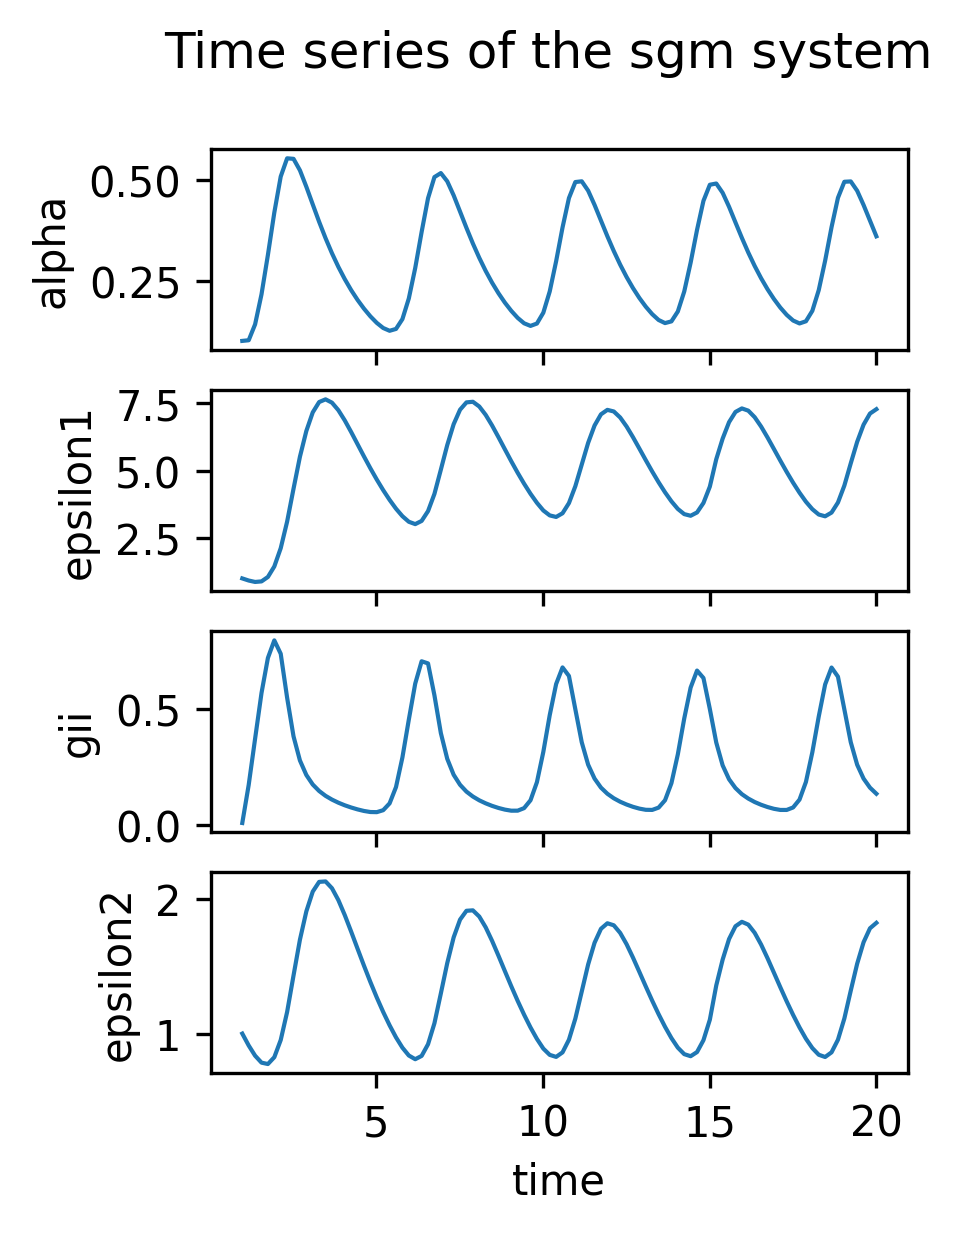

In [8]:
fig, axs = plt.subplots(4, sharex=True, figsize=(3,4))

# Check the solution
axs[0].plot(t, sol[:,:,0], '-', lw=1);
axs[0].set_ylabel('alpha')
axs[1].plot(t, sol[:,:,1], '-', lw=1);
axs[1].set_ylabel('epsilon1')
axs[2].plot(t, sol[:,:,2], '-', lw=1);
axs[2].set_ylabel('gii')
axs[3].plot(t, sol[:,:,3], '-', lw=1);
axs[3].set_ylabel('epsilon2')


plt.suptitle("Time series of the sgm system");
plt.xlabel("time");


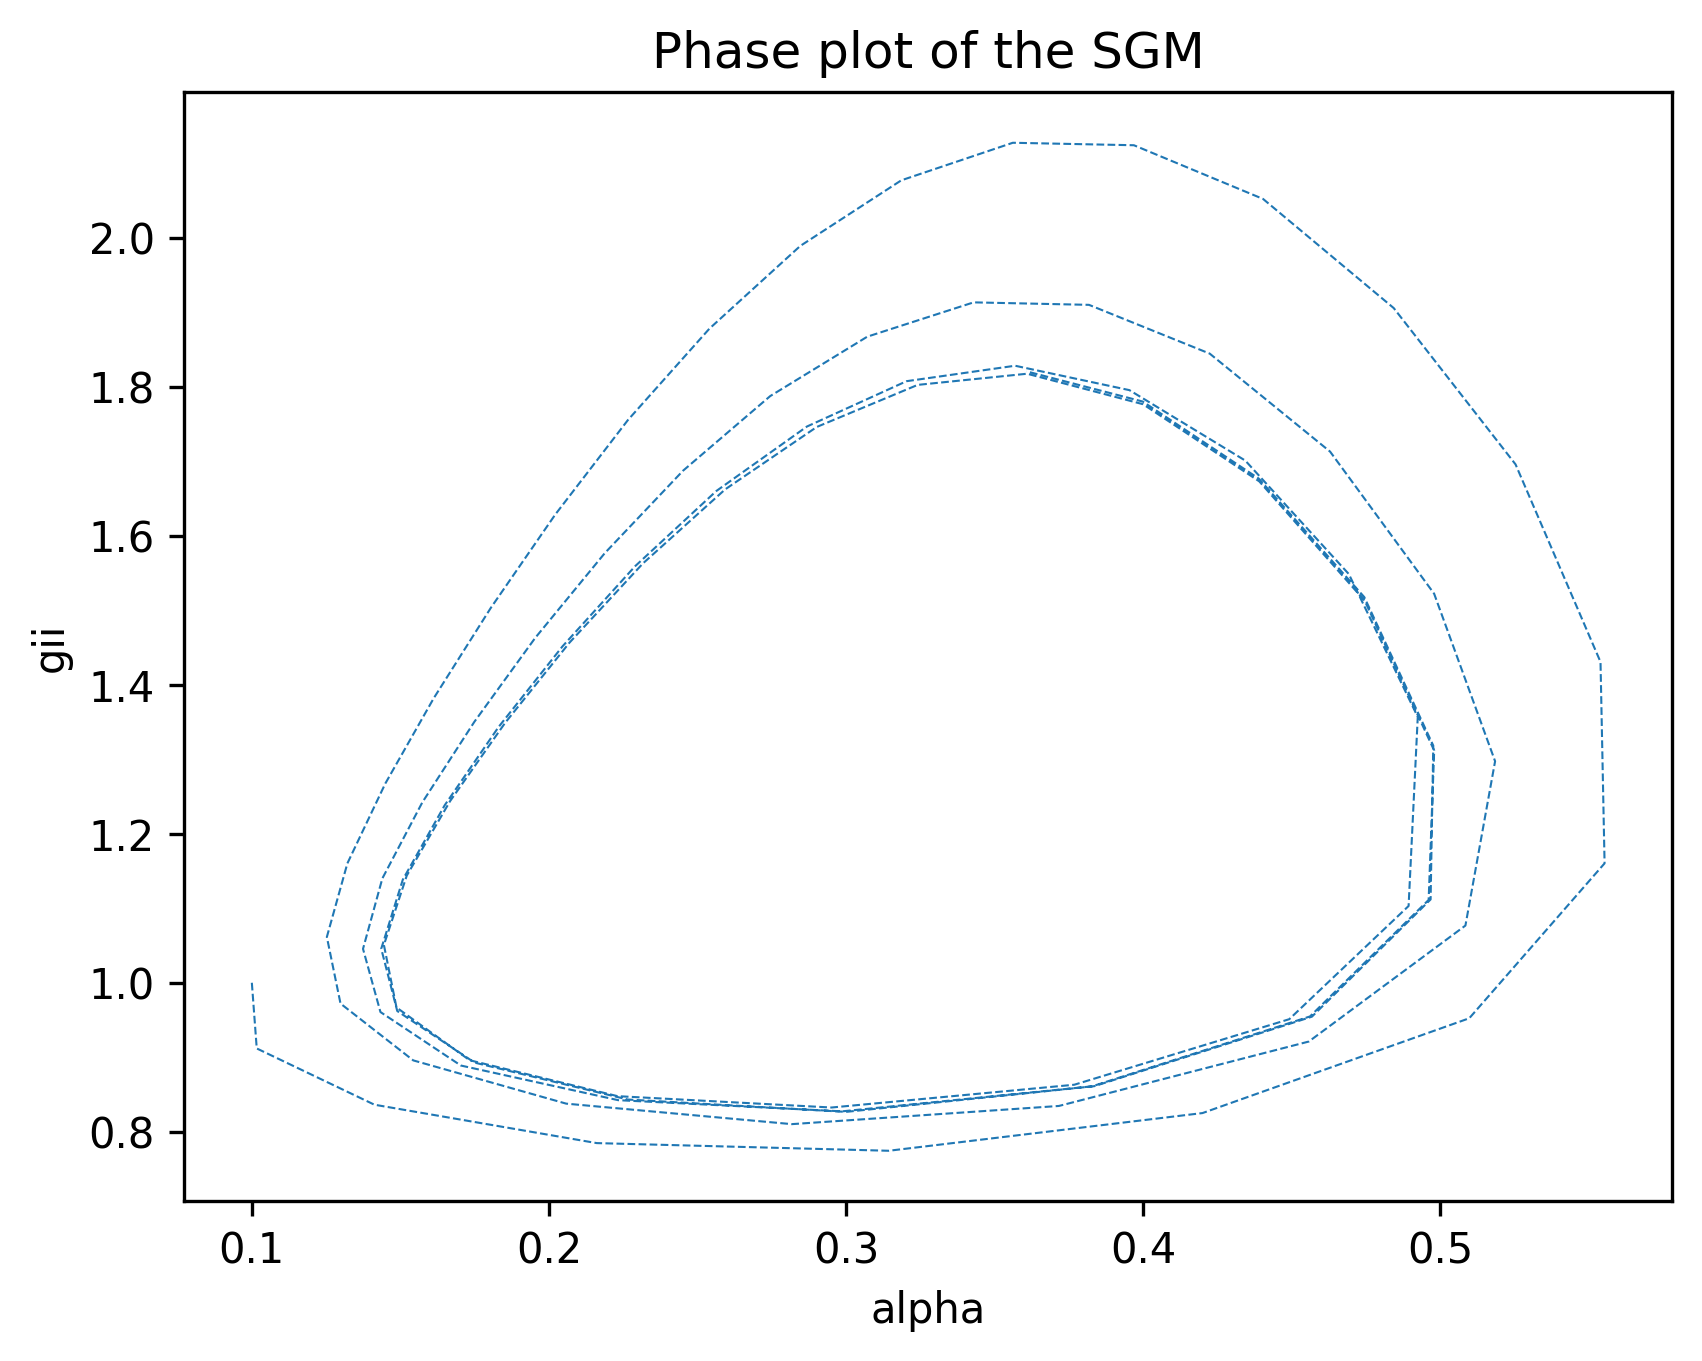

In [11]:
# Check the solution; 
plt.plot(sol[:,:,0], sol[:,:,3], '--',lw=0.5);
# plt.plot([0, 1], [0, 1])
plt.title("Phase plot of the SGM");
plt.xlabel("alpha");
plt.ylabel("gii");

# Region-wise IFTFT

In [13]:
with open('../neo_regions.pkl', 'rb') as handle:
    regions_dct = pkl.load(handle)
    
aal_labels_df = pd.read_csv(os.path.join(neo_dir, "UNC_infant-neo-aal.txt"), delim_whitespace=True, header=None)
aal_labels = aal_labels_df[1].values.tolist()

aal_labels_df['region'] = 'None'
for n, row in enumerate(aal_labels_df.iterrows()):
    aal_labels_df.at[n,'region'] = regions_dct[row[1][1]]

brain_regions = ['frontal','temporal', 'parietal', 'occipital']

band = "all"
if band == "all":
    freqband = np.where((freqs>=1) & (freqs<=20))[0]
elif band == "alpha":
    freqband = np.where((freqs>=8) & (freqs<=12))[0]
elif band == "beta":
    freqband = np.where((freqs>=13) & (freqs<=25))[0]


In [14]:
f_model = F(default_params)  # Your defined function

specs=[]
for alpha, gii in tqdm(zip(sol[:,:,0], sol[:,:,3]), total=len(sol[:,:,0])):

    if 0:
        # Cycle through freqs
        freq_model_out = []
        for i in range(len(freqband)):
            w = 2 * np.pi * freqs[freqband[i]]
            eigenvectors_ns, freq_model_i = network_transfer_Xk(params_single, alpha, gii, C, D, w, rois_with_MEG, SC)
            # eigvec_ns[:,:,i] = eigenvectors_ns
            freq_model_out.append(freq_model_i)
        # eigvec_ns_summed = np.sum(eigvec_ns[:,:,:],axis = 2)
        baby_spec = np.transpose(np.asarray(freq_model_out))
    else:
        # baby_spec = sgm_jax((params_single, C, D), alpha, gii)

        # Can batch in future (depends on time duration and GPU)
        alpha_0 = torch.tensor(alpha)
        gii_0 = torch.tensor(gii)
        alpha_0 = alpha_0.unsqueeze(0)
        gii_0 = gii_0.unsqueeze(0)
        baby_spec = f_model.f(alpha_0, gii_0)
        # baby_spec.shape is (90,50)

        # [ ] TODO adapt for batching
        baby_spec = baby_spec.squeeze(0)
        baby_spec = torch.square(baby_spec)
        
    specs.append(baby_spec)


  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
brain_regions = ['frontal','temporal', 'parietal', 'occipital']
baby_brain_idxs = perm_

# Group by region
all_baby_specs = {}
for c, cur_region in enumerate(brain_regions):
    all_baby_specs[cur_region] = []
    
for t in tqdm(range(len(specs))): # Right now just 1 baby
    for c, cur_region in enumerate(brain_regions):
        filtered_av, num_traces = 0, 0

        for idx in baby_brain_idxs:
            if aal_labels_df.at[idx,'region'] == cur_region:
                if 0:
                    spectrum = np.abs(baby_spec[idx,:])
                    filtered = np.convolve(spectrum, lpf, 'same')
                    filtered_av += filtered
                else:
                    baby_spec = specs[t]
                    baby_spec = baby_spec.numpy()
                    spectrum = baby_spec[idx,:]
                    filtered_av += np.abs(spectrum)
                num_traces += 1

        filtered_av /= num_traces
        # filtered_av = functions.mag2db(filtered_av)
        all_baby_specs[cur_region].append(filtered_av)




  0%|          | 0/100 [00:00<?, ?it/s]

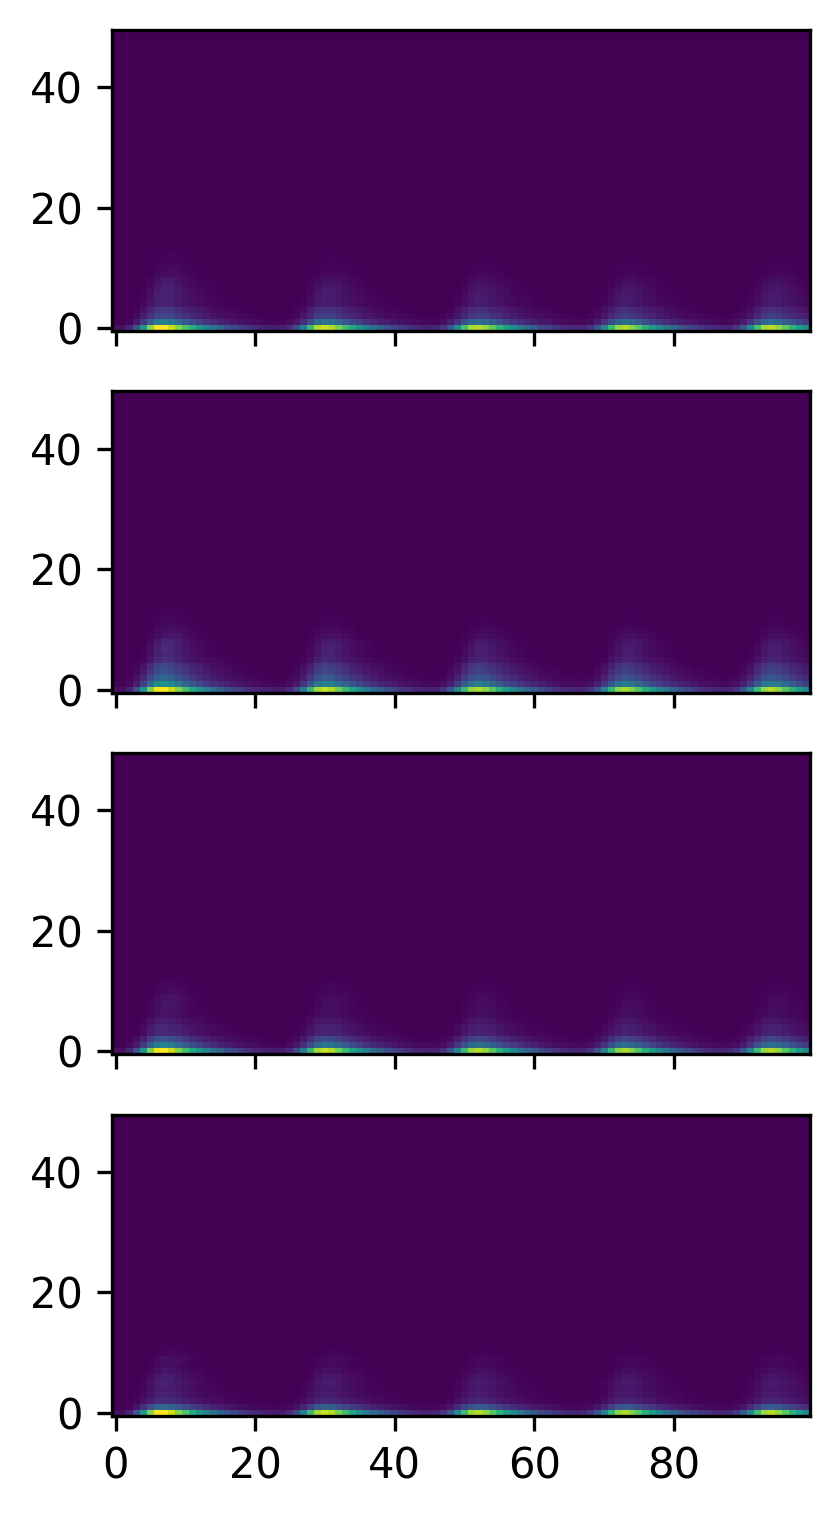

In [18]:
fig, ax = plt.subplots(4, 1, figsize = (3,6), sharex=True)

all_baby_ts = {}
for c, cur_region in enumerate(brain_regions):
    S = np.vstack(all_baby_specs[cur_region]).T # needs dim freq X time
    # y_inv = librosa.griffinlim(np.abs(S))
    y_inv = librosa.istft(S)
    all_baby_ts[cur_region] = y_inv

    ax[c].imshow(np.abs(S), origin='lower', aspect='auto')


In [21]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

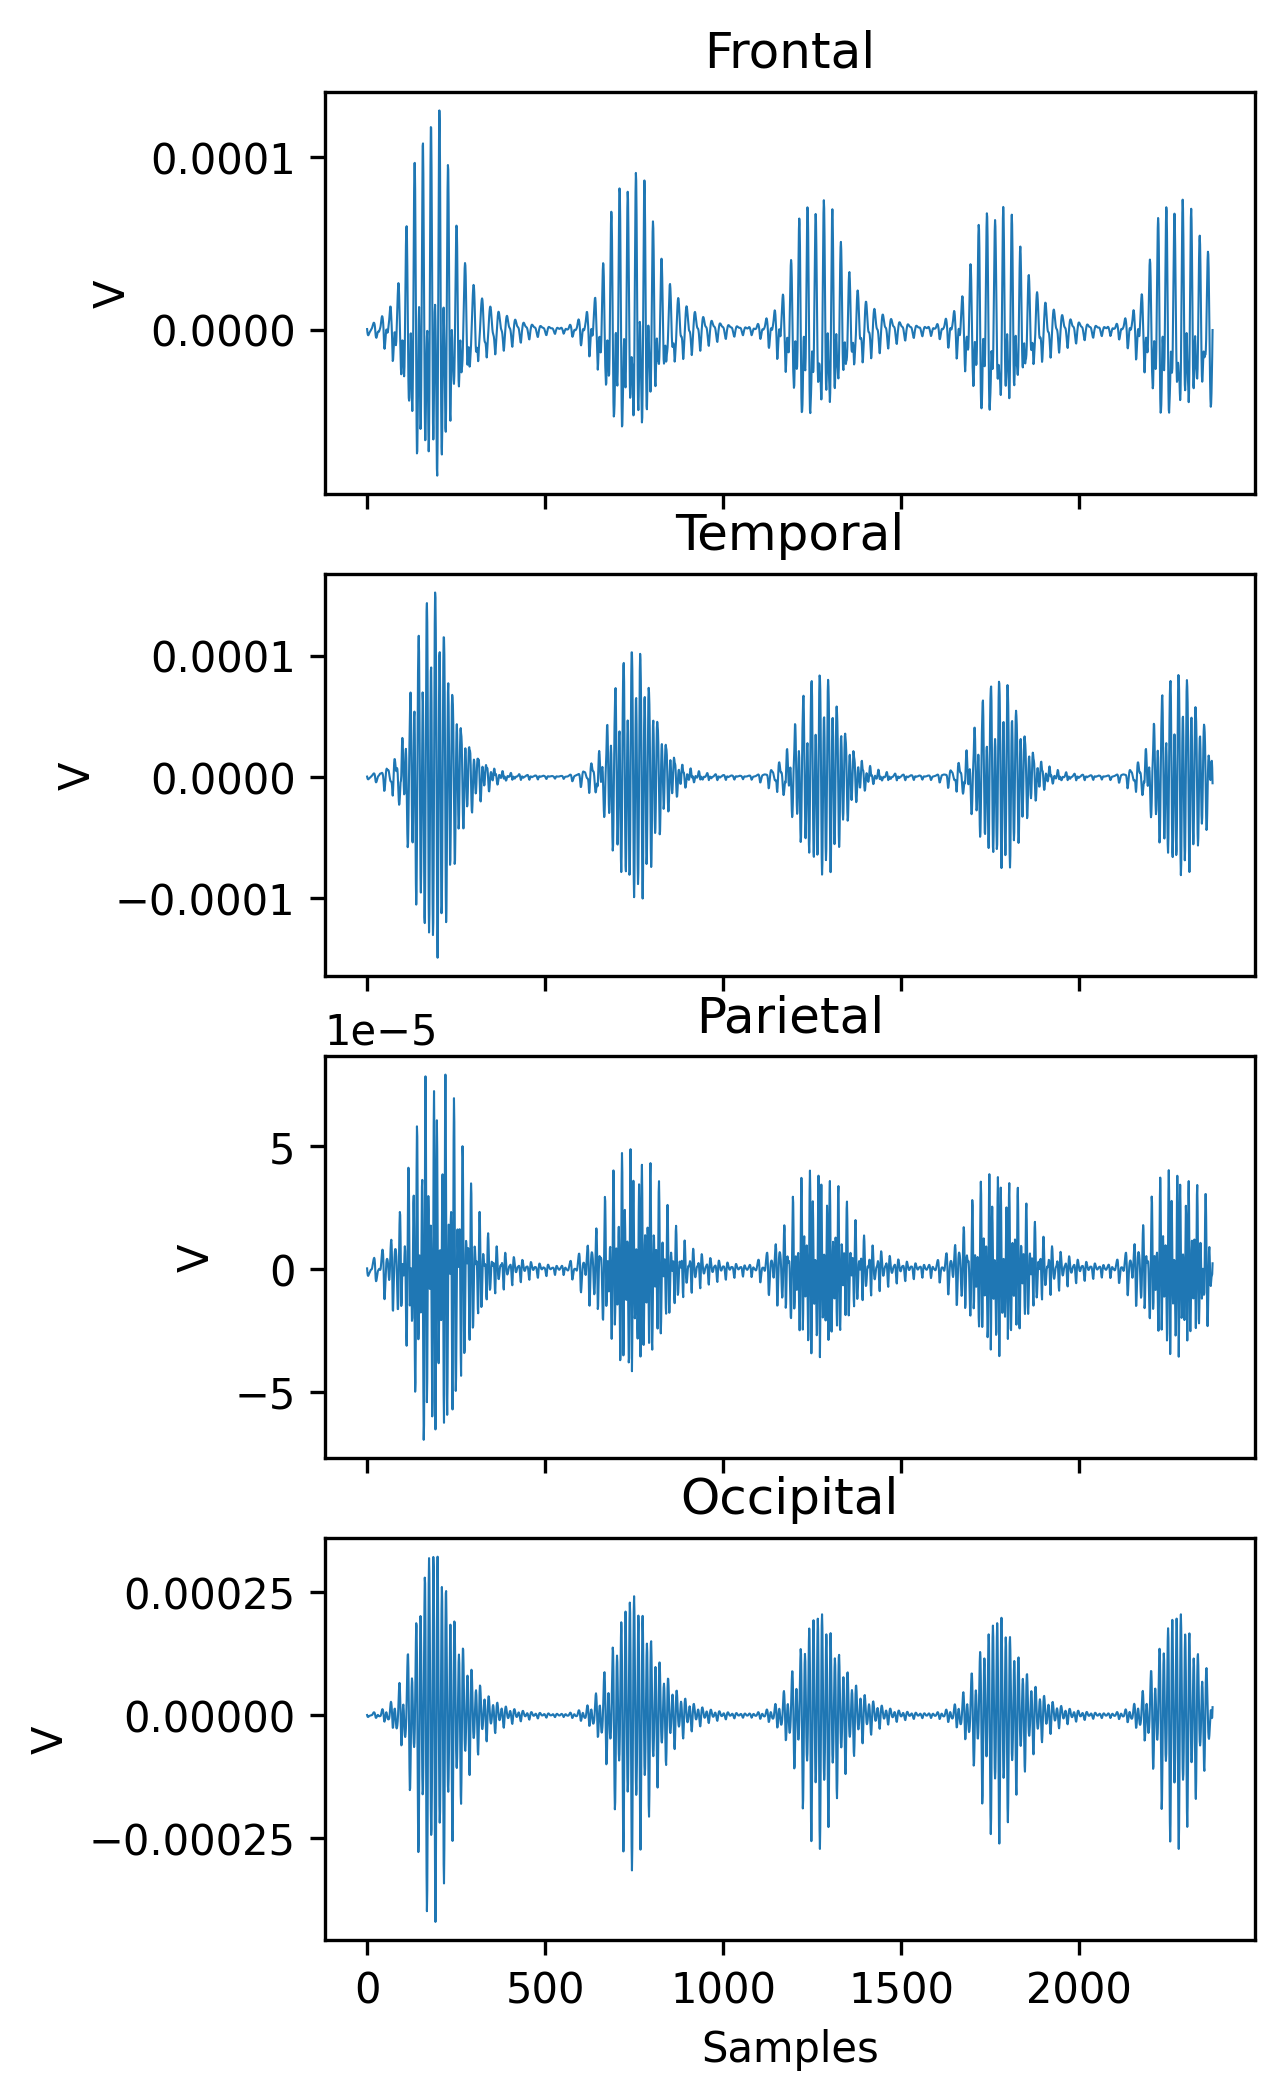

In [27]:

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

fig, axes = plt.subplots(4, 1, figsize = (4,8), sharex=True)
for c, cur_region in enumerate(brain_regions):

    eeg = butter_highpass_filter(all_baby_ts[cur_region], 1, 20)
    axes[c].plot(eeg, linewidth=.5)
    axes[c].set_title(cur_region.capitalize())
    axes[c].set_ylabel('V')


axes[-1].set_xlabel('Samples');
